<a href="https://colab.research.google.com/github/RBotL/Plant/blob/main/Final_Plant_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
import cv2
import os
import seaborn as sns
%matplotlib inline

from sklearn.metrics import classification_report, confusion_matrix

from imblearn.under_sampling import RandomUnderSampler
from keras.preprocessing.image import ImageDataGenerator
import itertools

In [2]:
from google.colab import drive
drive.mount('/content/drive')
#%cd drive/MyDrive/Plant

Mounted at /content/drive


# Preparing the dataset




In [3]:
!unzip -q "/content/drive/MyDrive/Plant/code_finalReport/New_Plant_disease_dataset.zip" -d "/content"

In [4]:
#Fetching the images for the train set
folder_path = "/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/"

X_train=[]
y_train=[]

width = 80
height = 80 # resize to 80x80 to solve the RAM issue 

for path, dirs, files in os.walk(folder_path):
    for file_name in dirs:
        files_path=folder_path+file_name
        for images in os.listdir(files_path):
            img=cv2.imread(files_path+'/'+images, cv2.IMREAD_COLOR)
            img_resized = cv2.resize(img, (width,height))
            X_train.append(np.array(img_resized)) 
            y_train.append(file_name.split('___')[0]) #plant

In [5]:
#Fetching the images for the test set
folder_path = "/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid/"

X_test=[]
y_test=[]

width = 80
height = 80 # resize to 80x80 to solve the RAM issue 

for path, dirs, files in os.walk(folder_path):
    for file_name in dirs:
        files_path=folder_path+file_name
        for images in os.listdir(files_path):
            img=cv2.imread(files_path+'/'+images, cv2.IMREAD_COLOR)
            img_resized = cv2.resize(img, (width,height))
            X_test.append(np.array(img_resized))
            y_test.append(file_name.split('___')[0]) #plant

In [6]:
# Transforming the lists into arrays
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

# Setting type of the data to float32
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Normalizing the data
X_train = X_train / 255
X_test = X_test / 255


In [7]:
# Encoding the labels
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y_le_train = le.fit_transform(y_train)
y_le_test = le.transform(y_test)

# Plotting functions

In [8]:
# Plotting functions

def plot_loss_accuracy(history, title=None):
    """
    Plots two graphs - loss per epoch and accuracy per epoch

    :param history: takes in a model history
    :param title: takes in a string for title of the plot
    """
    plt.figure(figsize=(12,4))
    plt.suptitle(title)
    plt.subplot(121)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss by epoch')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='right')
    
    plt.subplot(122)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model acc by epoch')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='right');

    import itertools

def plot_cm(y_true, y_pred, title=None):
    '''
    Plots a confusion matrix

    :param y_true: takes in the true labels of the dataset
    :param y_pred: takes in the predicted labels for the dataset
    :param title: takes in a string for title of the plot
    '''
    cnf_matrix = confusion_matrix(y_true, y_pred)

    classes = range(0,14)
    plt.figure(figsize=(10, 10))


    plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
    plt.title("title")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, cnf_matrix[i, j],
                horizontalalignment="center",
                color="white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

    plt.yticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13],['Apple', 'Blueberry', 'Cherry','Corn', 'Grape','Orange', 
                                                  'Peach','Pepper', 'Potato','Raspberry', 'Soybean','Squash','Strawberry','Tomato'])
    plt.ylabel('Real labels')
    plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13],['Apple', 'Blueberry', 'Cherry','Corn', 'Grape','Orange', 'Peach','Pepper', 
                                                  'Potato','Raspberry', 'Soybean','Squash','Strawberry','Tomato'],
                      rotation = 90)

    plt.xlabel('Predicted labels')
    plt.show()


def plot_errors(y_pred_model, y_pred_class, X, y_true):
    """
    Plots 9 random images that were labeled incorrectly

    :param y_pred_model: Takes in the the predictions generated by a model
    :param y_pred_class: Takes in the the prediction classes generated by a model
    :param X: Takes in the images
    :param y_true: Takes in the true labels of the images
    """
    plt.subplots(3, 3, figsize=(12, 12))
    plt.tight_layout()
    error_indexes = []
    map = {0:'Apple', 1:'Blueberry', 2:'Cherry', 3:'Corn', 4:'Grape', 5:'Orange',
           6:'Peach', 7:'Pepper', 8:'Potato', 9:'Raspberry', 10:'Soybean',
           11:'Squash', 12:'Strawberry', 13:'Tomato'}
    y_label = [map[i] for i in y_true]
    y_pred_label = [map[i] for i in y_pred_class]
    for i in range(len(y_pred_model)):
        if (y_pred_class[i] != y_true[i]):
          error_indexes += [i]

    j = 1
    for i in np.random.choice(error_indexes, size = 9):
        img = X[i] 
        #img = img.reshape(100, 100,3)
        
        plt.subplot(3, 3, j)
        j = j + 1
        plt.axis('off')

        plt.imshow(img,cmap = cm.binary, interpolation='None')
        plt.title('+ Label: ' + str(y_label[i]) \
                  + '\n' + 'Prediction: '+ str(y_pred_label[i]) \
                  + '\n' + 'Confidence: '+ str(round(y_pred_model[i,y_pred_class[i]], 2)))



# Models

Lenet and custom

In [ ]:
# Lenet model 
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
import tensorflow as tf

model_le = Sequential()

model_le.add(Conv2D(filters = 126,
                     input_shape = (80,80,3),
                     kernel_size = (5,5),
                     activation = 'relu'))

model_le.add(MaxPooling2D(pool_size = (2, 2)))

model_le.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))

model_le.add(MaxPooling2D(pool_size = (2, 2)))

model_le.add(Dropout(rate = 0.2))

model_le.add(Flatten())

model_le.add(Dense(units = 128,
                    activation = 'relu'))

model_le.add(Dense(units = 14,
                     activation='softmax'))

model_le.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_le_history = model_le.fit(X_train, y_le_train, batch_size=32, epochs=20, validation_data=(X_test, y_le_test))

Epoch 1/20
2197/2197 [==============================] - 55s 20ms/step - loss: 0.8055 - accuracy: 0.7390 - val_loss: 0.4380 - val_accuracy: 0.8562
Epoch 2/20
2197/2197 [==============================] - 41s 19ms/step - loss: 0.3231 - accuracy: 0.8918 - val_loss: 0.2616 - val_accuracy: 0.9158
Epoch 3/20
2197/2197 [==============================] - 42s 19ms/step - loss: 0.2081 - accuracy: 0.9293 - val_loss: 0.2639 - val_accuracy: 0.9153
Epoch 4/20
2197/2197 [==============================] - 41s 19ms/step - loss: 0.1515 - accuracy: 0.9482 - val_loss: 0.2586 - val_accuracy: 0.9174
Epoch 5/20
2197/2197 [==============================] - 41s 19ms/step - loss: 0.1141 - accuracy: 0.9607 - val_loss: 0.2376 - val_accuracy: 0.9306
Epoch 6/20
2197/2197 [==============================] - 41s 19ms/step - loss: 0.0953 - accuracy: 0.9677 - val_loss: 0.2192 - val_accuracy: 0.9368
Epoch 7/20
2197/2197 [==============================] - 41s 19ms/step - loss: 0.0789 - accuracy: 0.9726 - val_loss: 0.2472 -

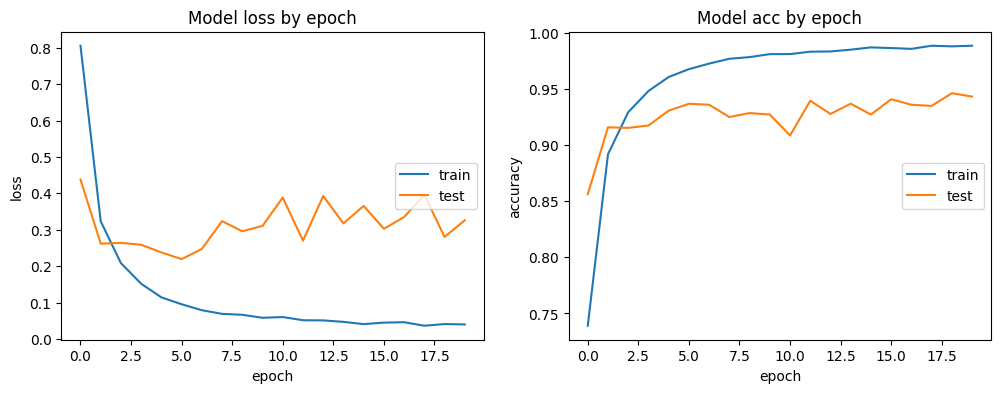

In [ ]:
# Plotting loss per epoch and accuracy per epoch
plot_loss_accuracy(model_le_history)

In [ ]:
# Predicting the plants of the test set
y_pred_model_le = model_le.predict(X_test)

# Getting the Plant with highest probabilty 
y_pred = np.argmax(y_pred_model_le, axis=1)

# Classification report
print(classification_report(y_le_test, y_pred))


550/550 [==============================] - 2s 4ms/step
              precision    recall  f1-score   support

           0       0.87      0.94      0.90      1943
           1       0.92      0.92      0.92       454
           2       0.95      0.95      0.95       877
           3       0.97      0.98      0.98      1829
           4       1.00      0.97      0.98      1805
           5       0.97      0.97      0.97       503
           6       0.91      0.94      0.92       891
           7       0.86      0.94      0.90       975
           8       0.94      0.90      0.92      1426
           9       0.98      0.92      0.95       445
          10       0.95      0.93      0.94       505
          11       0.94      0.92      0.93       434
          12       0.97      0.93      0.95       900
          13       0.96      0.94      0.95      4585

    accuracy                           0.94     17572
   macro avg       0.94      0.94      0.94     17572
weighted avg       0.94  

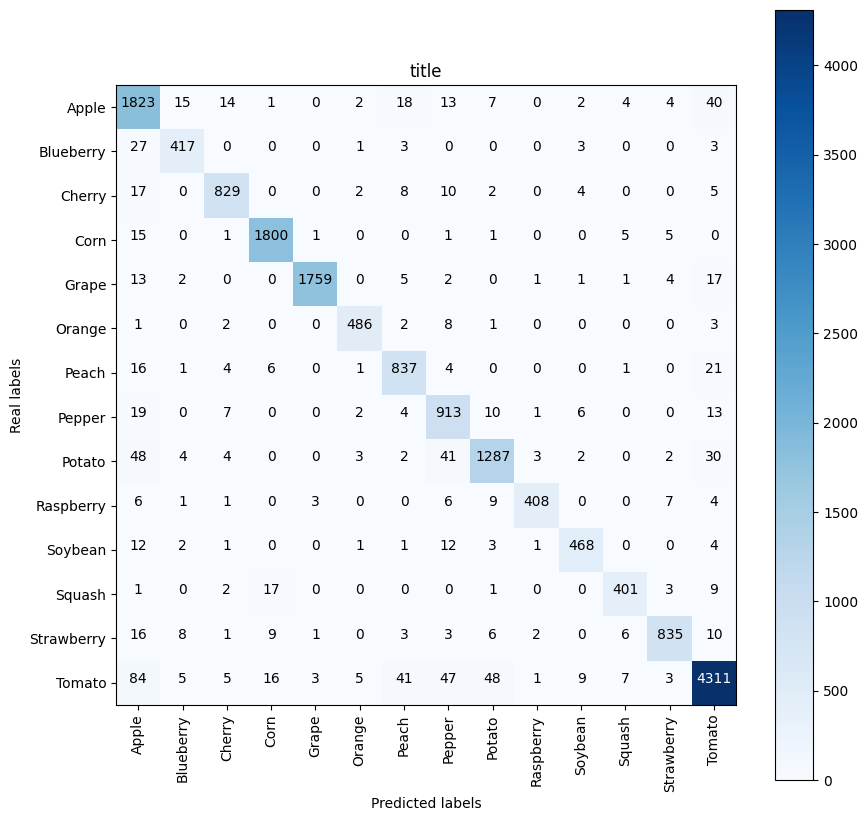

In [ ]:
# Confusion Matrix
plot_cm(y_le_test, y_pred)

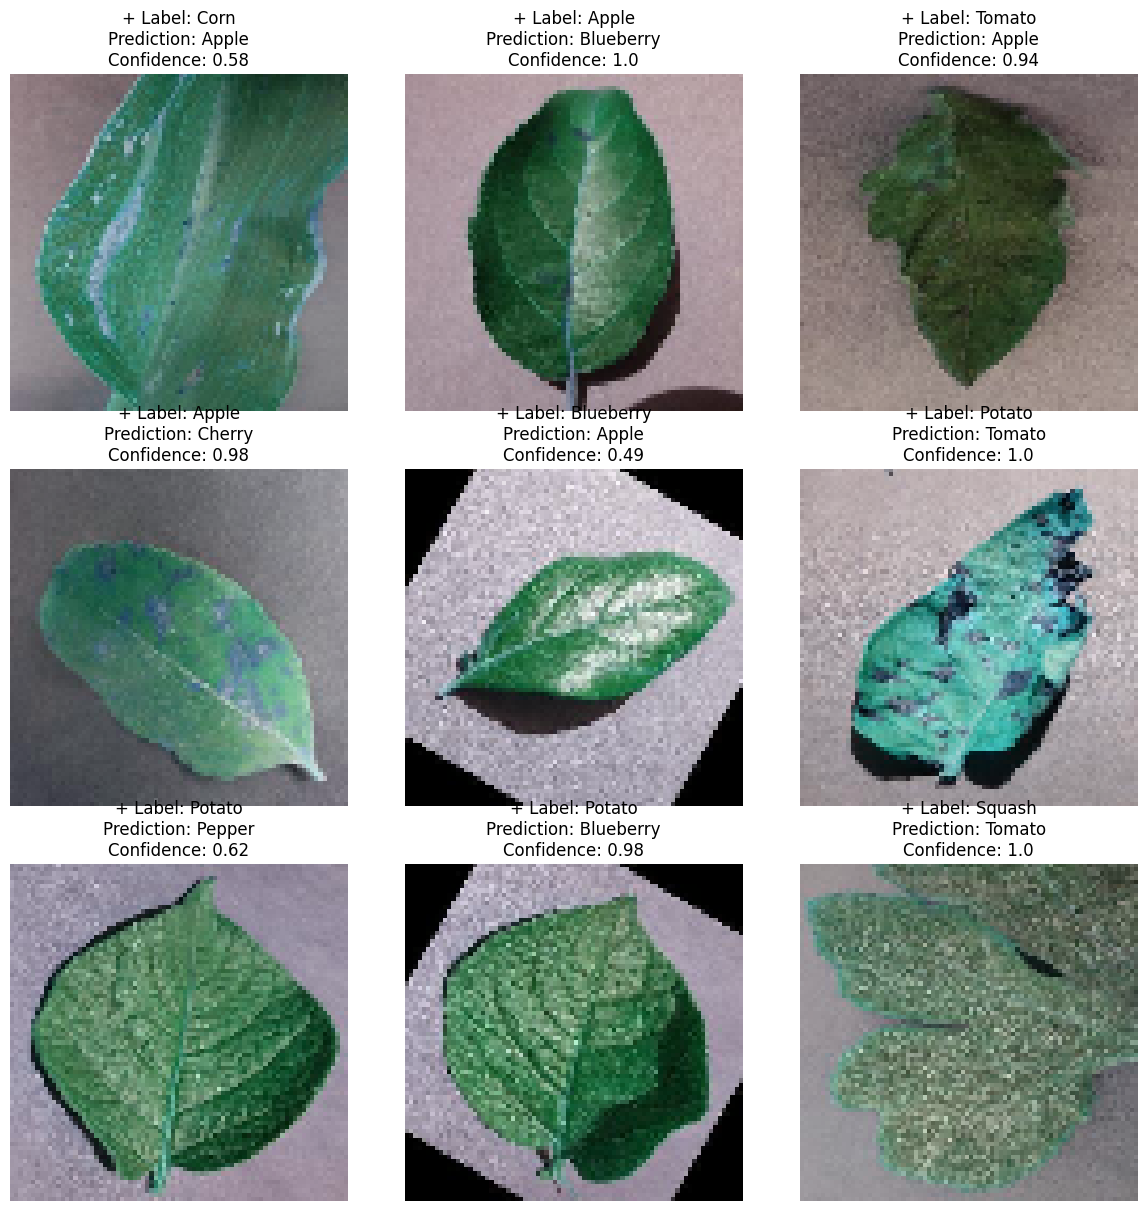

In [ ]:
# Ploting images that were labeled wrong
plot_errors(y_pred_model_le, y_pred, X_test, y_le_test)

In [9]:
# Custom model

from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPool2D
import tensorflow as tf


model_2 = Sequential()

model_2.add(Conv2D(filters=128, kernel_size=(5, 5), 
                        strides=(2, 2), activation="relu", 
                        input_shape=(80, 80, 3)))
model_2.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
model_2.add(Conv2D(filters=256, kernel_size=(3, 3), 
                        strides=(1, 1), activation="relu", 
                        padding="same"))
model_2.add(Conv2D(filters=128, kernel_size=(3, 3), 
                        strides=(1, 1), activation="relu", 
                        padding="same"))
model_2.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
model_2.add(Flatten())
model_2.add(Dense(2048, activation="relu"))
model_2.add(Dropout(0.5))
model_2.add(Dense(14, activation="softmax"))


model_2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_2_history = model_2.fit(X_train, y_le_train, batch_size=32, epochs=20, validation_data=(X_test, y_le_test))

Epoch 1/20
2197/2197 [==============================] - 45s 15ms/step - loss: 0.8544 - accuracy: 0.7161 - val_loss: 0.4936 - val_accuracy: 0.8292
Epoch 2/20
2197/2197 [==============================] - 32s 15ms/step - loss: 0.3457 - accuracy: 0.8830 - val_loss: 0.2494 - val_accuracy: 0.9210
Epoch 3/20
2197/2197 [==============================] - 32s 15ms/step - loss: 0.2459 - accuracy: 0.9185 - val_loss: 0.2990 - val_accuracy: 0.9002
Epoch 4/20
2197/2197 [==============================] - 33s 15ms/step - loss: 0.1979 - accuracy: 0.9349 - val_loss: 0.1821 - val_accuracy: 0.9408
Epoch 5/20
2197/2197 [==============================] - 33s 15ms/step - loss: 0.1674 - accuracy: 0.9448 - val_loss: 0.2966 - val_accuracy: 0.9046
Epoch 6/20
2197/2197 [==============================] - 33s 15ms/step - loss: 0.1481 - accuracy: 0.9520 - val_loss: 0.2051 - val_accuracy: 0.9346
Epoch 7/20
2197/2197 [==============================] - 33s 15ms/step - loss: 0.1440 - accuracy: 0.9545 - val_loss: 0.1782 -

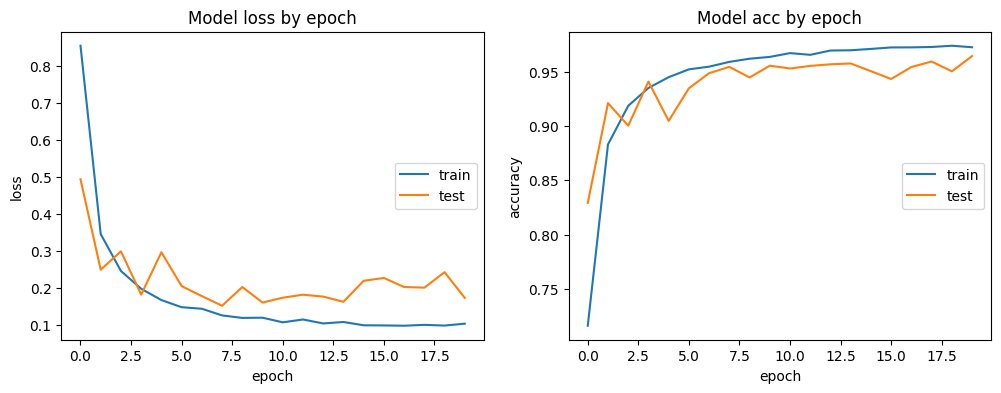

In [10]:
# Plotting loss per epoch and accuracy per epoch
plot_loss_accuracy(model_2_history)

In [11]:
# predicting the the plants of the test set
y_pred_model_2 = model_2.predict(X_test)

# getting the Plant with highest probabilty 
y_pred = np.argmax(y_pred_model_2, axis=1)

# classification report
print(classification_report(y_le_test, y_pred))


550/550 [==============================] - 2s 4ms/step
              precision    recall  f1-score   support

           0       0.91      0.96      0.93      1943
           1       0.96      0.95      0.96       454
           2       0.96      0.98      0.97       877
           3       0.99      0.99      0.99      1829
           4       0.99      0.99      0.99      1805
           5       0.98      0.98      0.98       503
           6       0.96      0.93      0.94       891
           7       0.96      0.91      0.93       975
           8       0.95      0.95      0.95      1426
           9       0.99      0.95      0.97       445
          10       0.96      0.97      0.96       505
          11       0.96      0.97      0.97       434
          12       0.95      0.99      0.97       900
          13       0.98      0.96      0.97      4585

    accuracy                           0.96     17572
   macro avg       0.96      0.96      0.96     17572
weighted avg       0.96  

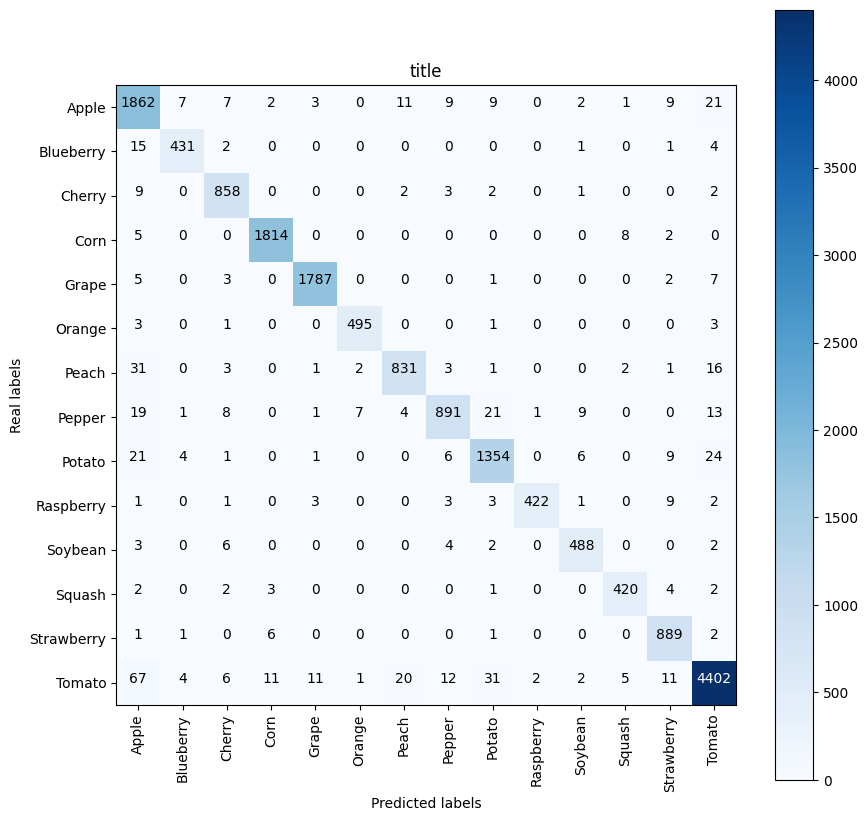

In [12]:
# Confusion matrix
plot_cm(y_le_test, y_pred)

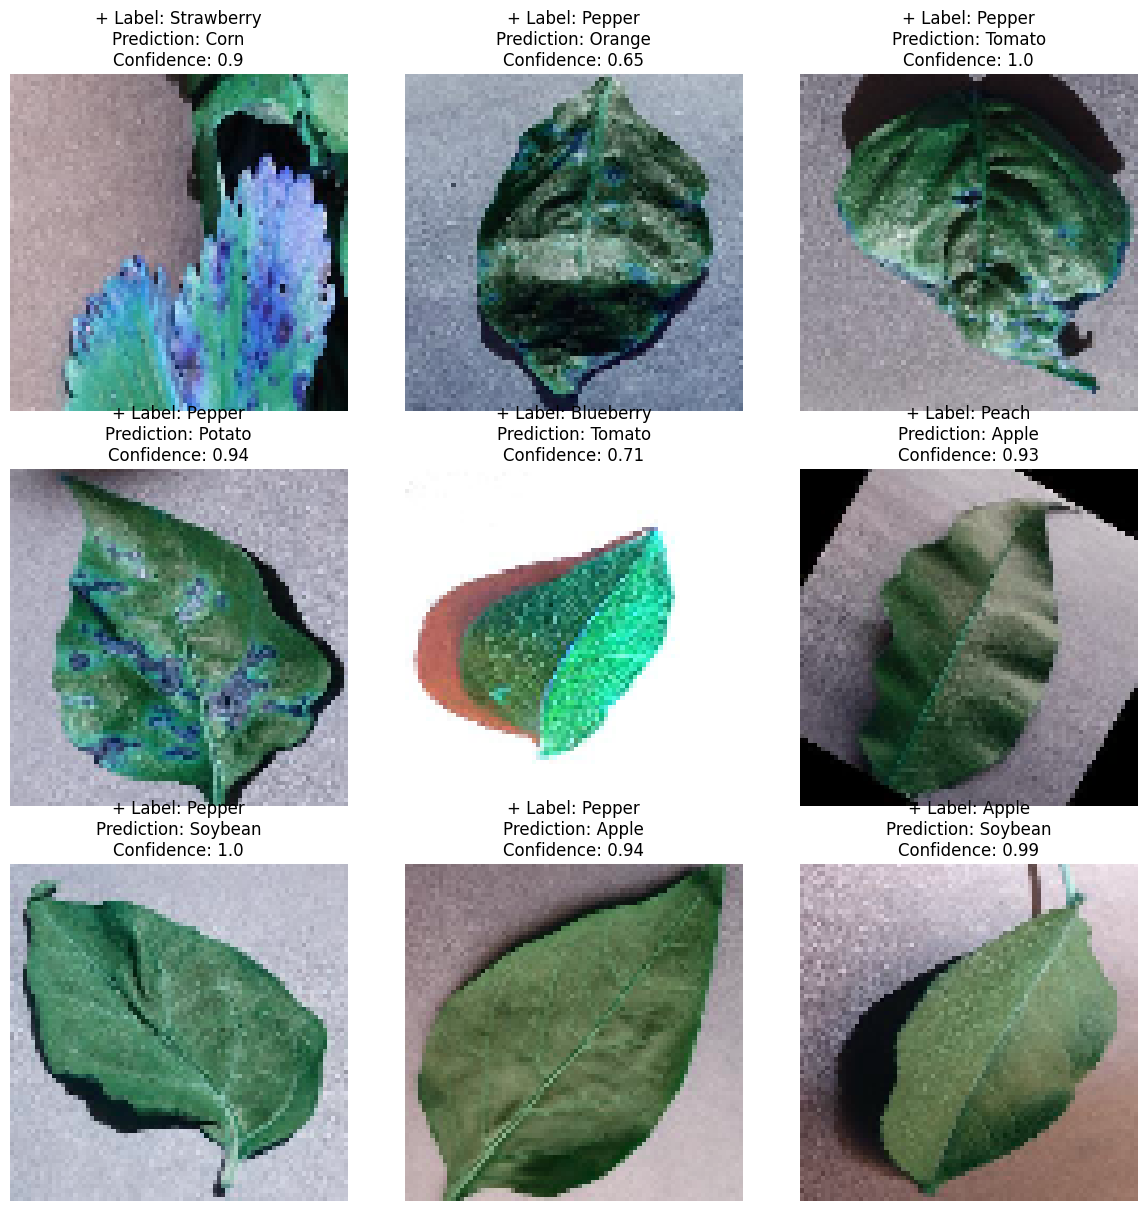

In [13]:
# Ploting images that were labeled wrong
plot_errors(y_pred_model_2, y_pred, X_test, y_le_test)

# RandomUnderSampler

Models: Lenet and custom model



In [16]:
# UnderSampling:

X_train_reshaped = X_train.reshape([-1, 80*80*3])

rUs=RandomUnderSampler(random_state=222)

(X_train_ru,y_train_ru) = rUs.fit_resample(X_train_reshaped, y_le_train)


print('Undersampled classes :', dict(pd.Series(y_train_ru).value_counts()))

#
X_train_ru = X_train_ru.reshape([-1, 80,80,3])

# Shape of X_train and y_train
print('Shape of X Train:', X_train_ru.shape)
print('Shape of y train:',y_train_ru.shape)


Undersampled classes : {0: 1736, 1: 1736, 2: 1736, 3: 1736, 4: 1736, 5: 1736, 6: 1736, 7: 1736, 8: 1736, 9: 1736, 10: 1736, 11: 1736, 12: 1736, 13: 1736}
Shape of X Train: (24304, 80, 80, 3)
Shape of y train: (24304,)


In [17]:
del(X_train, y_train)

In [ ]:
# Lenet with RandomUndersampler
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
import tensorflow as tf

model_le_ru = Sequential()

model_le_ru.add(Conv2D(filters = 126,
                     input_shape = (80,80,3),
                     kernel_size = (5,5),
                     activation = 'relu'))

model_le_ru.add(MaxPooling2D(pool_size = (2, 2)))

model_le_ru.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))

model_le_ru.add(MaxPooling2D(pool_size = (2, 2)))

model_le_ru.add(Dropout(rate = 0.2))

model_le_ru.add(Flatten())

model_le_ru.add(Dense(units = 128,
                    activation = 'relu'))

model_le_ru.add(Dense(units = 14,
                     activation='softmax'))

model_le_ru.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_le_ru_history = model_le_ru.fit(X_train_ru, y_train_ru, batch_size=32, epochs=20, validation_data=(X_test, y_le_test))

Epoch 1/20
760/760 [==============================] - 29s 25ms/step - loss: 1.2845 - accuracy: 0.5842 - val_loss: 0.9886 - val_accuracy: 0.6770
Epoch 2/20
760/760 [==============================] - 16s 21ms/step - loss: 0.6566 - accuracy: 0.7847 - val_loss: 0.7140 - val_accuracy: 0.7663
Epoch 3/20
760/760 [==============================] - 16s 22ms/step - loss: 0.4199 - accuracy: 0.8605 - val_loss: 0.5178 - val_accuracy: 0.8322
Epoch 4/20
760/760 [==============================] - 17s 22ms/step - loss: 0.2980 - accuracy: 0.9000 - val_loss: 0.5196 - val_accuracy: 0.8370
Epoch 5/20
760/760 [==============================] - 17s 22ms/step - loss: 0.2140 - accuracy: 0.9294 - val_loss: 0.5775 - val_accuracy: 0.8319
Epoch 6/20
760/760 [==============================] - 17s 22ms/step - loss: 0.1798 - accuracy: 0.9383 - val_loss: 0.5553 - val_accuracy: 0.8383
Epoch 7/20
760/760 [==============================] - 17s 22ms/step - loss: 0.1461 - accuracy: 0.9513 - val_loss: 0.4449 - val_accuracy:

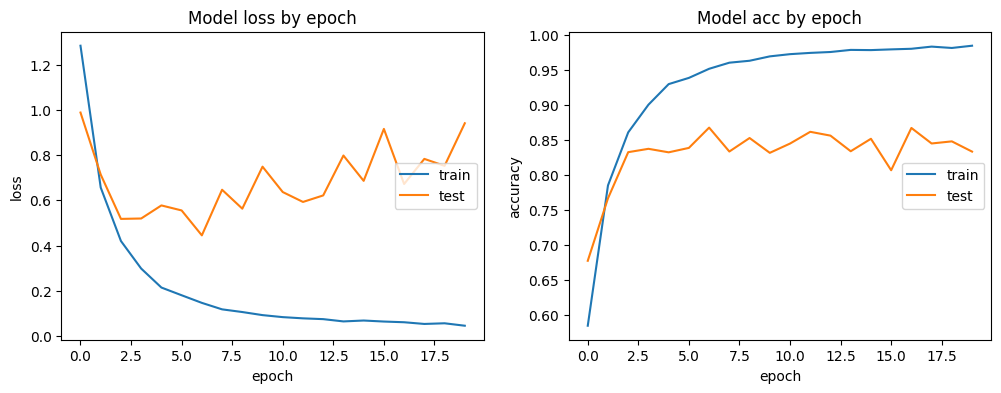

In [ ]:
# Plotting loss per epoch and accuracy per epoch
plot_loss_accuracy(model_le_ru_history)

In [ ]:
# predicting the the plants of the test set
y_pred_model_le_ru = model_le_ru.predict(X_test)

# getting the Plant with highest probabilty 
y_pred = np.argmax(y_pred_model_le_ru, axis=1)

# classification report
print(classification_report(y_le_test, y_pred))

550/550 [==============================] - 2s 4ms/step
              precision    recall  f1-score   support

           0       0.70      0.78      0.73      1943
           1       0.59      0.98      0.74       454
           2       0.82      0.90      0.86       877
           3       0.94      0.97      0.95      1829
           4       0.95      0.96      0.95      1805
           5       0.91      0.96      0.94       503
           6       0.74      0.90      0.82       891
           7       0.63      0.88      0.73       975
           8       0.88      0.72      0.79      1426
           9       0.78      0.97      0.86       445
          10       0.81      0.91      0.86       505
          11       0.82      0.94      0.88       434
          12       0.82      0.91      0.86       900
          13       0.96      0.68      0.80      4585

    accuracy                           0.83     17572
   macro avg       0.81      0.89      0.84     17572
weighted avg       0.86  

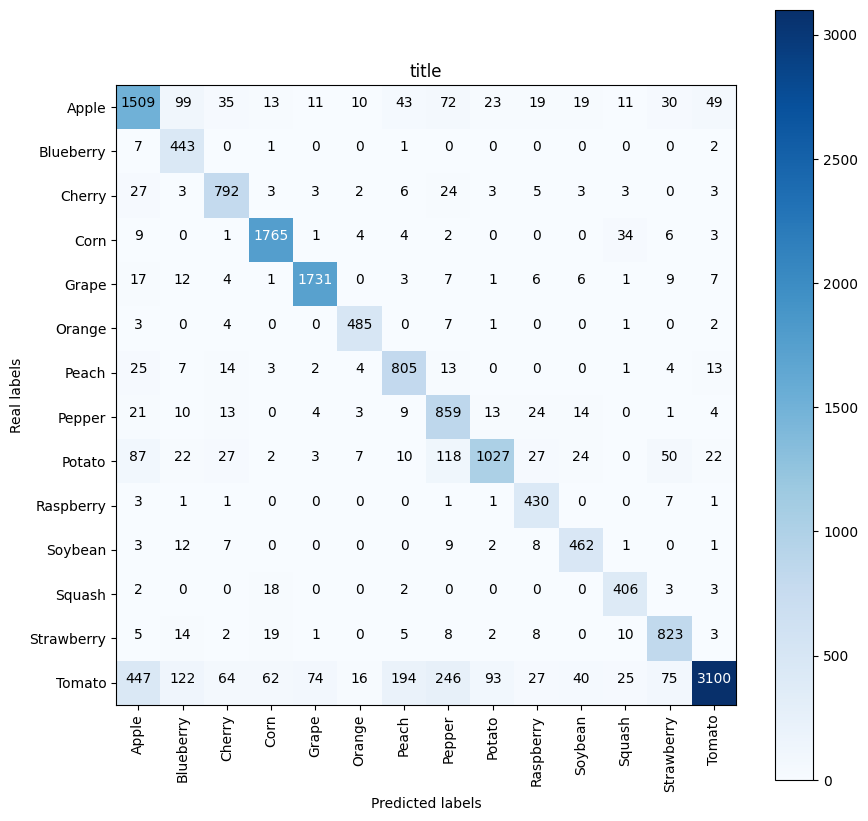

In [ ]:
# Confusion Matrix
plot_cm(y_le_test, y_pred)

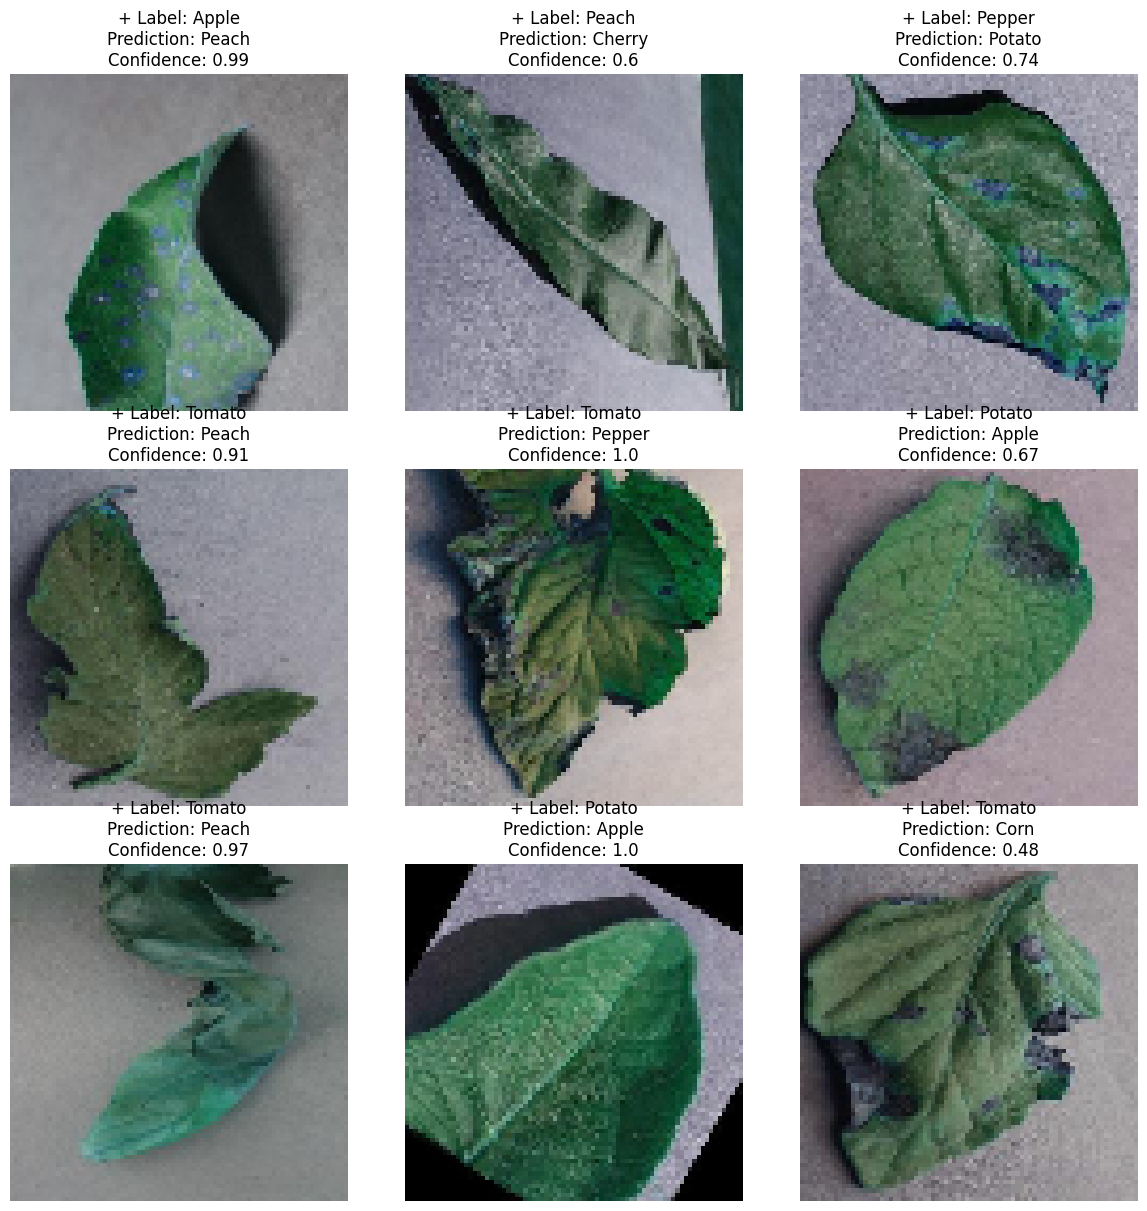

In [ ]:
# Ploting images that were labeled wrong
plot_errors(y_pred_model_le_ru, y_pred, X_test, y_le_test)

In [16]:
# Custom model
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPool2D
import tensorflow as tf


model_2_ru = Sequential()

model_2_ru.add(Conv2D(filters=128, kernel_size=(5, 5), 
                        strides=(2, 2), activation="relu", 
                        input_shape=(80, 80, 3)))
model_2_ru.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
model_2_ru.add(Conv2D(filters=256, kernel_size=(3, 3), 
                        strides=(1, 1), activation="relu", 
                        padding="same"))
model_2_ru.add(Conv2D(filters=128, kernel_size=(3, 3), 
                        strides=(1, 1), activation="relu", 
                        padding="same"))
model_2_ru.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
model_2_ru.add(Flatten())
model_2_ru.add(Dense(2048, activation="relu"))
model_2_ru.add(Dropout(0.5))
model_2_ru.add(Dense(14, activation="softmax"))


model_2_ru.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_2_ru_history = model_2_ru.fit(X_train_ru, y_train_ru, batch_size=32, epochs=20, validation_data=(X_test, y_le_test))

Epoch 1/20
760/760 [==============================] - 18s 22ms/step - loss: 1.3982 - accuracy: 0.5449 - val_loss: 1.1428 - val_accuracy: 0.6192
Epoch 2/20
760/760 [==============================] - 13s 17ms/step - loss: 0.6878 - accuracy: 0.7733 - val_loss: 0.6632 - val_accuracy: 0.7826
Epoch 3/20
760/760 [==============================] - 13s 17ms/step - loss: 0.4792 - accuracy: 0.8413 - val_loss: 0.4785 - val_accuracy: 0.8407
Epoch 4/20
760/760 [==============================] - 13s 17ms/step - loss: 0.3683 - accuracy: 0.8796 - val_loss: 0.4835 - val_accuracy: 0.8421
Epoch 5/20
760/760 [==============================] - 13s 17ms/step - loss: 0.3031 - accuracy: 0.8980 - val_loss: 0.4391 - val_accuracy: 0.8558
Epoch 6/20
760/760 [==============================] - 13s 17ms/step - loss: 0.2471 - accuracy: 0.9175 - val_loss: 0.5098 - val_accuracy: 0.8453
Epoch 7/20
760/760 [==============================] - 14s 18ms/step - loss: 0.2147 - accuracy: 0.9292 - val_loss: 0.4343 - val_accuracy:

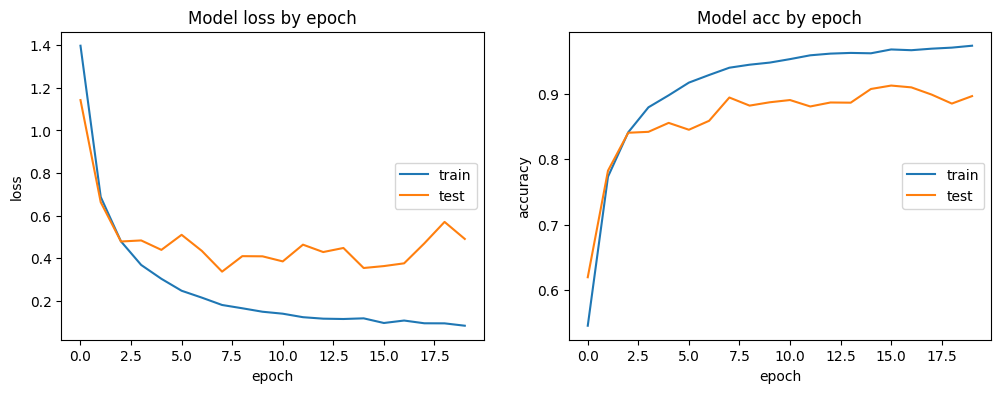

In [17]:
# Plotting loss per epoch and accuracy per epoch
plot_loss_accuracy(model_2_ru_history)

In [18]:
# predicting the the plants of the test set
y_pred_model_2_ru = model_2_ru.predict(X_test)

# getting the Plant with highest probabilty 
y_pred = np.argmax(y_pred_model_2_ru, axis=1)

# classification report
print(classification_report(y_le_test, y_pred))


550/550 [==============================] - 3s 5ms/step
              precision    recall  f1-score   support

           0       0.89      0.71      0.79      1943
           1       0.69      0.98      0.81       454
           2       0.94      0.92      0.93       877
           3       0.98      0.98      0.98      1829
           4       0.99      0.97      0.98      1805
           5       0.92      0.98      0.95       503
           6       0.71      0.96      0.82       891
           7       0.75      0.94      0.83       975
           8       0.86      0.88      0.87      1426
           9       0.85      0.98      0.91       445
          10       0.95      0.93      0.94       505
          11       0.93      0.96      0.95       434
          12       0.95      0.91      0.93       900
          13       0.94      0.86      0.90      4585

    accuracy                           0.90     17572
   macro avg       0.88      0.92      0.90     17572
weighted avg       0.91  

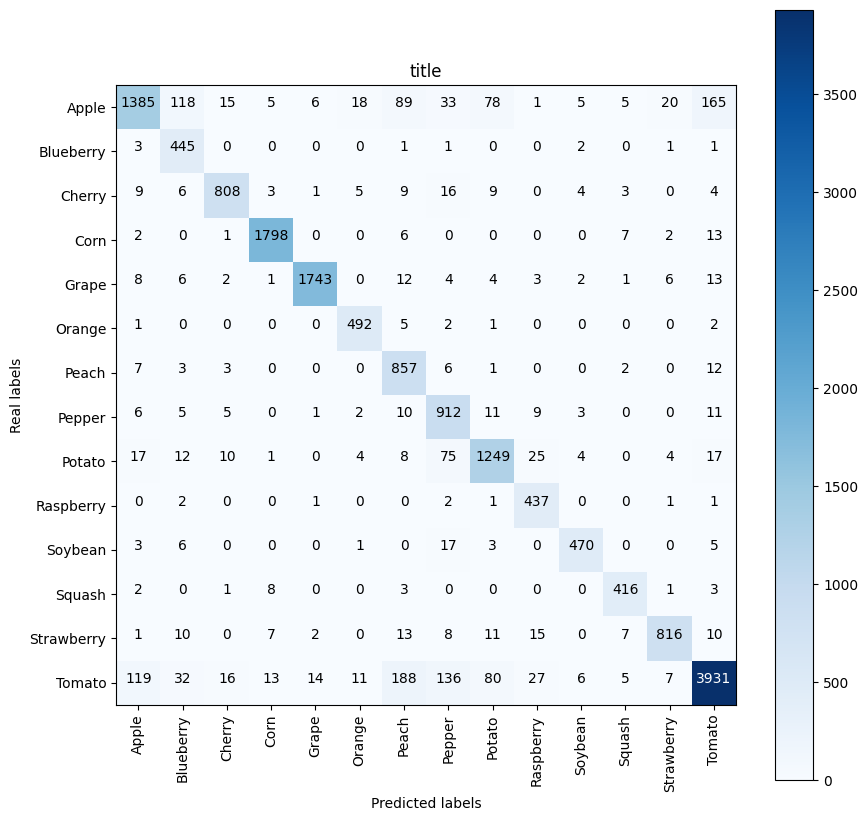

In [19]:
# Confusion Matrix
plot_cm(y_le_test, y_pred)

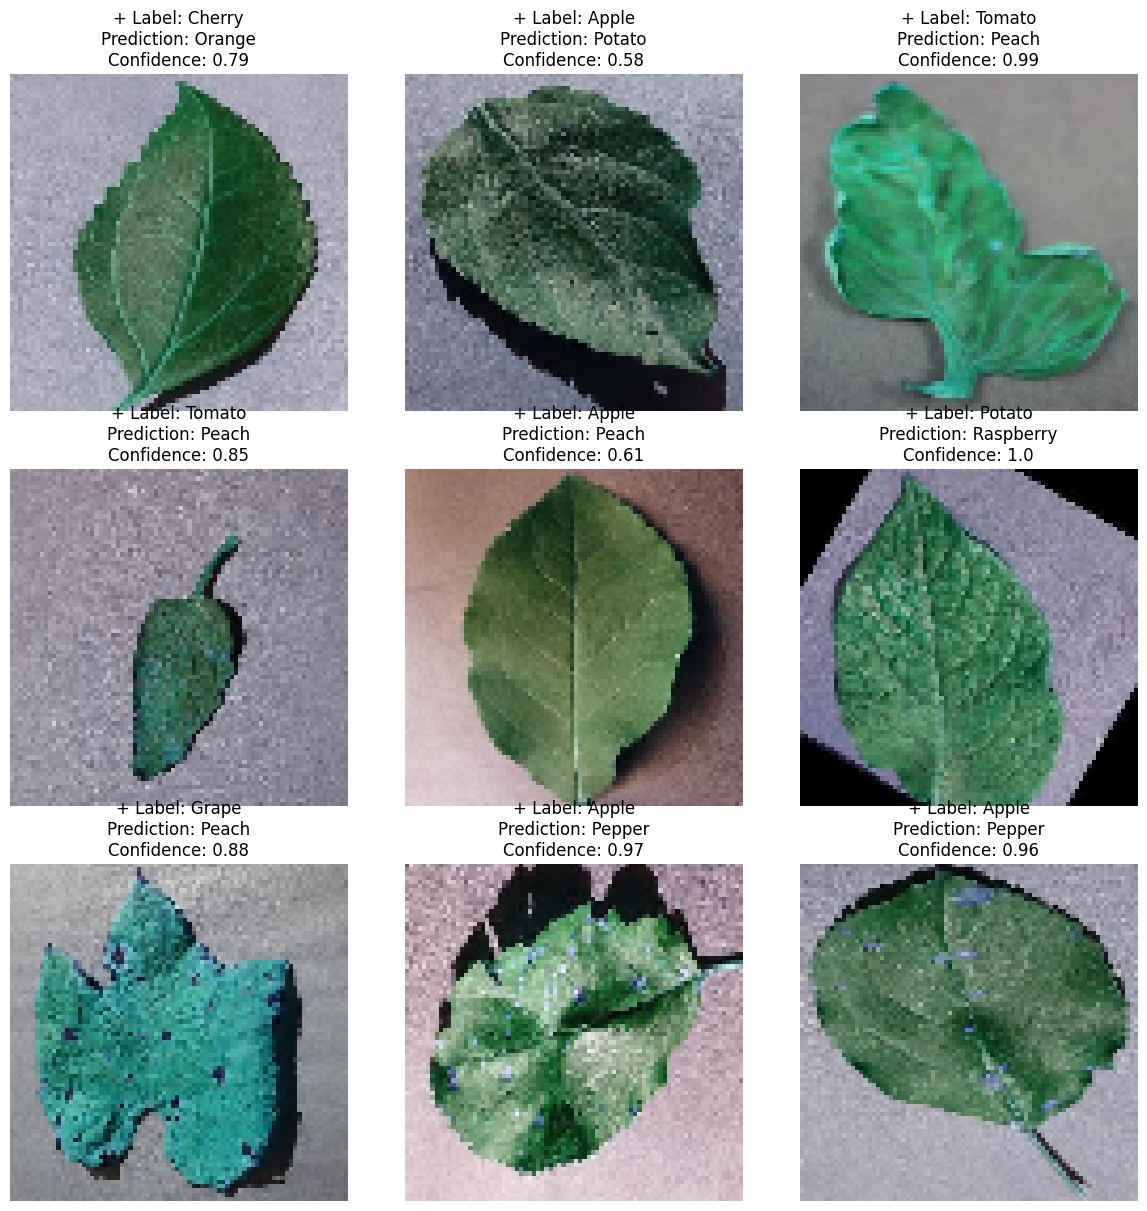

In [20]:
# Ploting images that were labeled wrong
plot_errors(y_pred_model_2_ru, y_pred, X_test, y_le_test)

# ImageDataGenerator

Custom model



In [9]:
train_data_generator = ImageDataGenerator(
        rotation_range=50,
        width_shift_range=0.4,
        height_shift_range=0.4,
        zoom_range=[0.8, 1.2],
        horizontal_flip=True)

test_data_generator = ImageDataGenerator()

In [10]:
# Generating data
batch_size = 64

train_data = train_data_generator.flow(X_train, y_le_train, batch_size=batch_size)
#test_data = test_data_generator.flow(X_test, y_le_test, batch_size=batch_size)

In [11]:
# Custom model

from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPool2D
import tensorflow as tf


model_2_gen = Sequential()

model_2_gen.add(Conv2D(filters=128, kernel_size=(5, 5), 
                        strides=(2, 2), activation="relu", 
                        input_shape=(80, 80, 3)))
model_2_gen.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
model_2_gen.add(Conv2D(filters=256, kernel_size=(3, 3), 
                        strides=(1, 1), activation="relu", 
                        padding="same"))
model_2_gen.add(Conv2D(filters=128, kernel_size=(3, 3), 
                        strides=(1, 1), activation="relu", 
                        padding="same"))
model_2_gen.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
model_2_gen.add(Flatten())
model_2_gen.add(Dense(2048, activation="relu"))
model_2_gen.add(Dropout(0.5))
model_2_gen.add(Dense(14, activation="softmax"))


model_2_gen.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_2_gen_history = model_2_gen.fit(train_data, epochs=50, validation_data=(X_test, y_le_test))

Epoch 1/50
1099/1099 [==============================] - 125s 103ms/step - loss: 1.6199 - accuracy: 0.4595 - val_loss: 1.1090 - val_accuracy: 0.6156
Epoch 2/50
1099/1099 [==============================] - 111s 101ms/step - loss: 0.9251 - accuracy: 0.6844 - val_loss: 0.4633 - val_accuracy: 0.8446
Epoch 3/50
1099/1099 [==============================] - 111s 101ms/step - loss: 0.6367 - accuracy: 0.7834 - val_loss: 0.3618 - val_accuracy: 0.8810
Epoch 4/50
1099/1099 [==============================] - 111s 101ms/step - loss: 0.5100 - accuracy: 0.8272 - val_loss: 0.3425 - val_accuracy: 0.8862
Epoch 5/50
1099/1099 [==============================] - 110s 100ms/step - loss: 0.4430 - accuracy: 0.8513 - val_loss: 0.2830 - val_accuracy: 0.9096
Epoch 6/50
1099/1099 [==============================] - 110s 100ms/step - loss: 0.3926 - accuracy: 0.8693 - val_loss: 0.2545 - val_accuracy: 0.9157
Epoch 7/50
1099/1099 [==============================] - 110s 100ms/step - loss: 0.3621 - accuracy: 0.8791 - val_

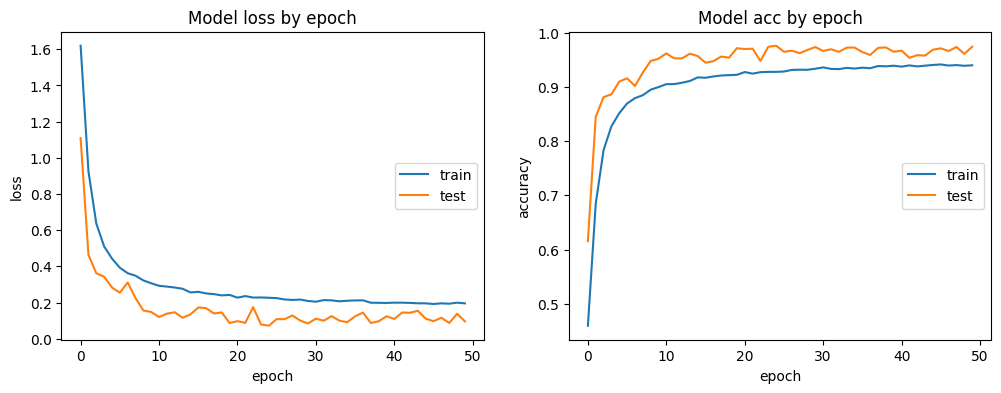

In [12]:
# Plotting loss per epoch and accuracy per epoch
plot_loss_accuracy(model_2_gen_history)

In [13]:
# predicting the the plants of the test set
y_pred_model_2_gen = model_2_gen.predict(X_test)

# getting the Plant with highest probabilty 
y_pred = np.argmax(y_pred_model_2_gen, axis=1)

# classification report
print(classification_report(y_le_test, y_pred))


550/550 [==============================] - 2s 4ms/step
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1943
           1       0.99      0.94      0.96       454
           2       0.98      0.97      0.98       877
           3       0.99      1.00      0.99      1829
           4       0.99      0.99      0.99      1805
           5       1.00      0.97      0.99       503
           6       0.95      0.96      0.96       891
           7       0.85      0.99      0.92       975
           8       0.97      0.96      0.97      1426
           9       1.00      0.98      0.99       445
          10       0.99      0.87      0.93       505
          11       0.99      0.98      0.99       434
          12       0.99      0.99      0.99       900
          13       0.98      0.98      0.98      4585

    accuracy                           0.97     17572
   macro avg       0.97      0.97      0.97     17572
weighted avg       0.98  

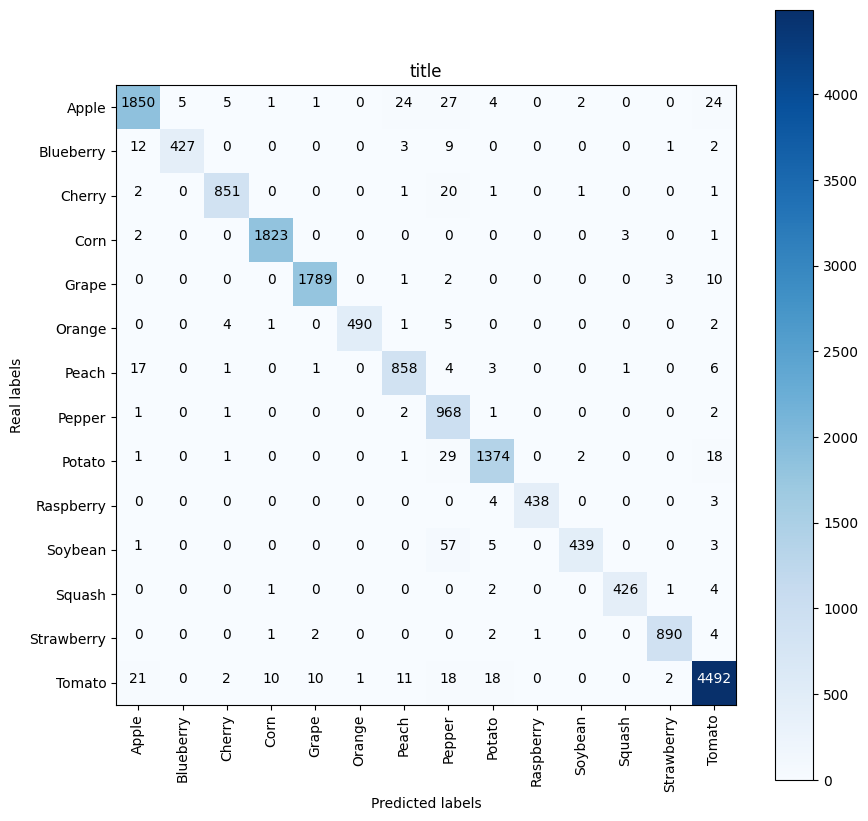

In [14]:
# Confusion Matrix
plot_cm(y_le_test, y_pred)

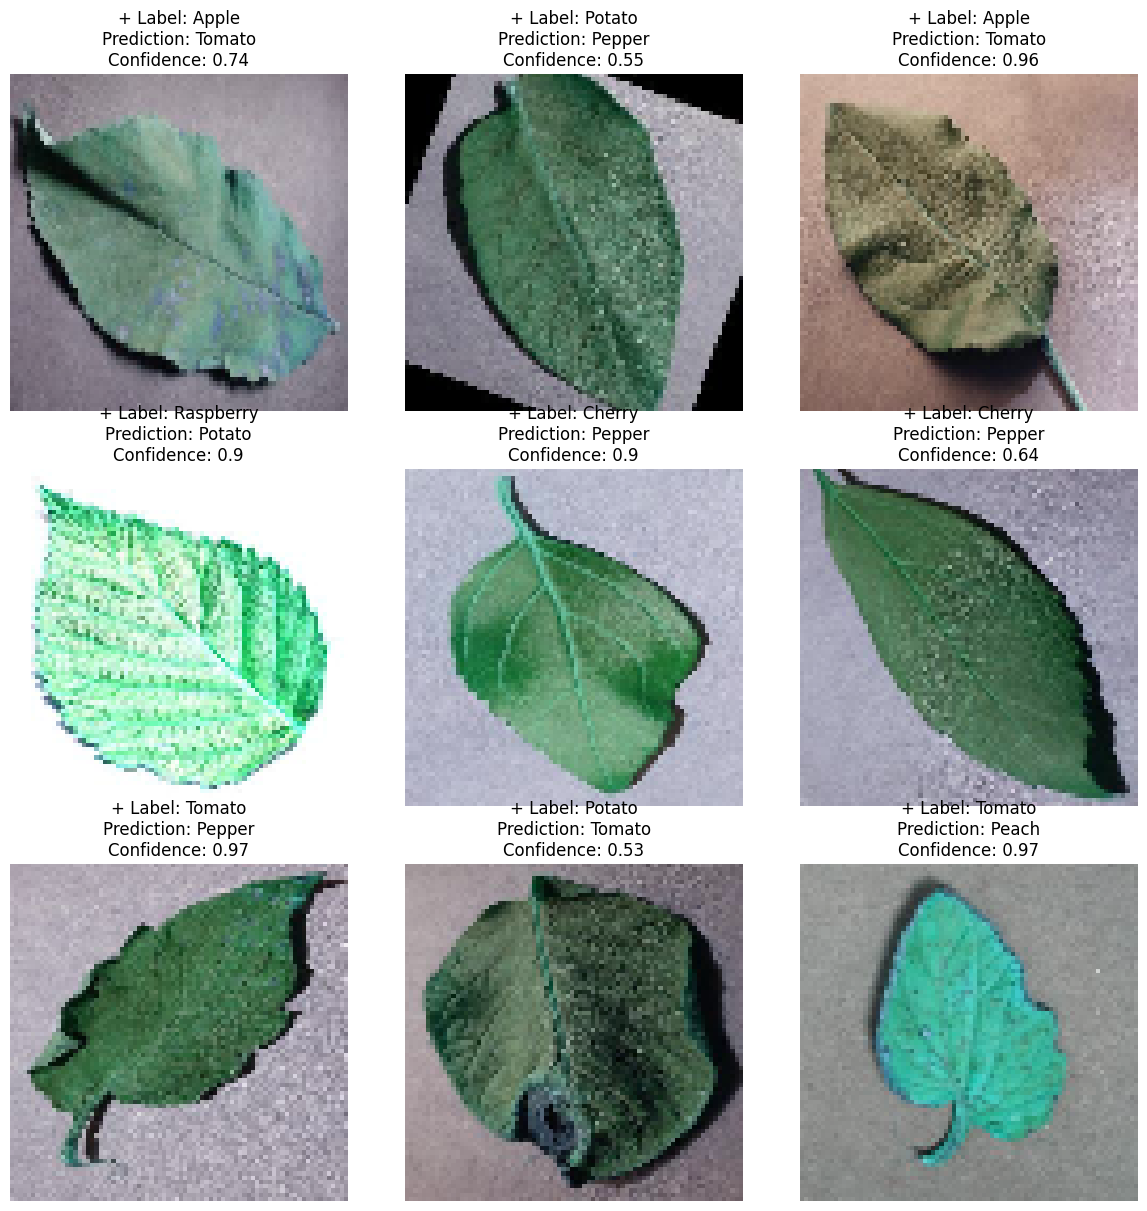

In [15]:
# Ploting images that were labeled wrong
plot_errors(y_pred_model_2_gen, y_pred, X_test, y_le_test)

# ImageDataGenerator with RandomUnderSampler

Custom model

In [18]:
# Generating data for the undersampled dataset
batch_size = 128

train_data_ru = train_data_generator.flow(X_train_ru, y_train_ru, batch_size=batch_size)
#test_data = test_data_generator.flow(X_test, y_le_test, batch_size=batch_size)

In [19]:
# Custom model

from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPool2D
import tensorflow as tf


model_2_ru_gen = Sequential()

model_2_ru_gen.add(Conv2D(filters=128, kernel_size=(5, 5), 
                        strides=(2, 2), activation="relu", 
                        input_shape=(80, 80, 3)))
model_2_ru_gen.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
model_2_ru_gen.add(Conv2D(filters=256, kernel_size=(3, 3), 
                        strides=(1, 1), activation="relu", 
                        padding="same"))
model_2_ru_gen.add(Conv2D(filters=128, kernel_size=(3, 3), 
                        strides=(1, 1), activation="relu", 
                        padding="same"))
model_2_ru_gen.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
model_2_ru_gen.add(Flatten())
model_2_ru_gen.add(Dense(2048, activation="relu"))
model_2_ru_gen.add(Dropout(0.5))
model_2_ru_gen.add(Dense(14, activation="softmax"))


model_2_ru_gen.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_2_ru_gen_history = model_2_ru_gen.fit(train_data_ru, epochs=50, validation_data=(X_test, y_le_test))

Epoch 1/50
190/190 [==============================] - 44s 218ms/step - loss: 2.1530 - accuracy: 0.2802 - val_loss: 2.0452 - val_accuracy: 0.2347
Epoch 2/50
190/190 [==============================] - 38s 202ms/step - loss: 1.4582 - accuracy: 0.5091 - val_loss: 1.4867 - val_accuracy: 0.4460
Epoch 3/50
190/190 [==============================] - 39s 203ms/step - loss: 1.1328 - accuracy: 0.6212 - val_loss: 1.3875 - val_accuracy: 0.5028
Epoch 4/50
190/190 [==============================] - 39s 203ms/step - loss: 0.9762 - accuracy: 0.6718 - val_loss: 1.4594 - val_accuracy: 0.5051
Epoch 5/50
190/190 [==============================] - 39s 204ms/step - loss: 0.8676 - accuracy: 0.7120 - val_loss: 1.0551 - val_accuracy: 0.6343
Epoch 6/50
190/190 [==============================] - 38s 202ms/step - loss: 0.7526 - accuracy: 0.7506 - val_loss: 0.7051 - val_accuracy: 0.7577
Epoch 7/50
190/190 [==============================] - 38s 202ms/step - loss: 0.6653 - accuracy: 0.7784 - val_loss: 0.5264 - val_ac

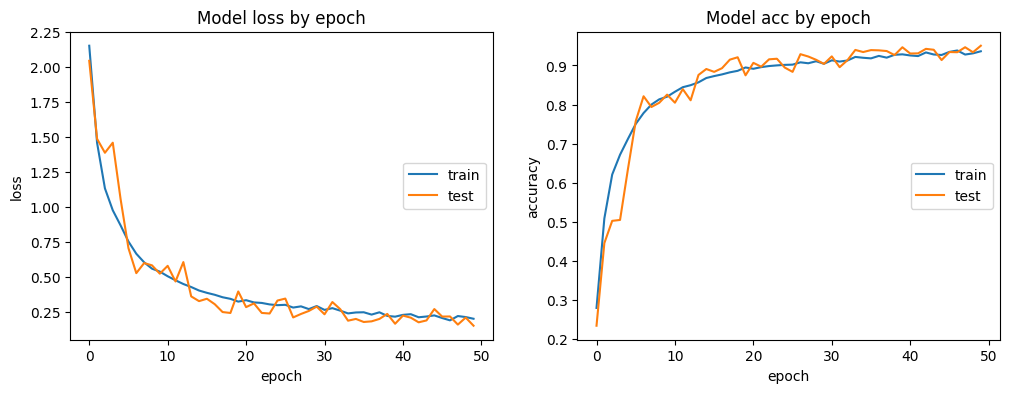

In [20]:
# Plotting loss per epoch and accuracy per epoch
plot_loss_accuracy(model_2_ru_gen_history)

In [21]:
# predicting the the plants of the test set
y_pred_model_2_ru_gen = model_2_ru_gen.predict(X_test)

# getting the Plant with highest probabilty 
y_pred = np.argmax(y_pred_model_2_ru_gen, axis=1)

# classification report
print(classification_report(y_le_test, y_pred))


550/550 [==============================] - 2s 4ms/step
              precision    recall  f1-score   support

           0       0.97      0.90      0.93      1943
           1       0.90      0.98      0.94       454
           2       0.95      0.97      0.96       877
           3       0.99      0.99      0.99      1829
           4       0.96      0.97      0.96      1805
           5       0.97      0.99      0.98       503
           6       0.86      0.96      0.91       891
           7       0.86      0.97      0.91       975
           8       0.93      0.92      0.93      1426
           9       0.93      1.00      0.96       445
          10       0.96      0.95      0.96       505
          11       0.98      0.99      0.99       434
          12       0.98      0.97      0.97       900
          13       0.97      0.93      0.95      4585

    accuracy                           0.95     17572
   macro avg       0.94      0.96      0.95     17572
weighted avg       0.95  

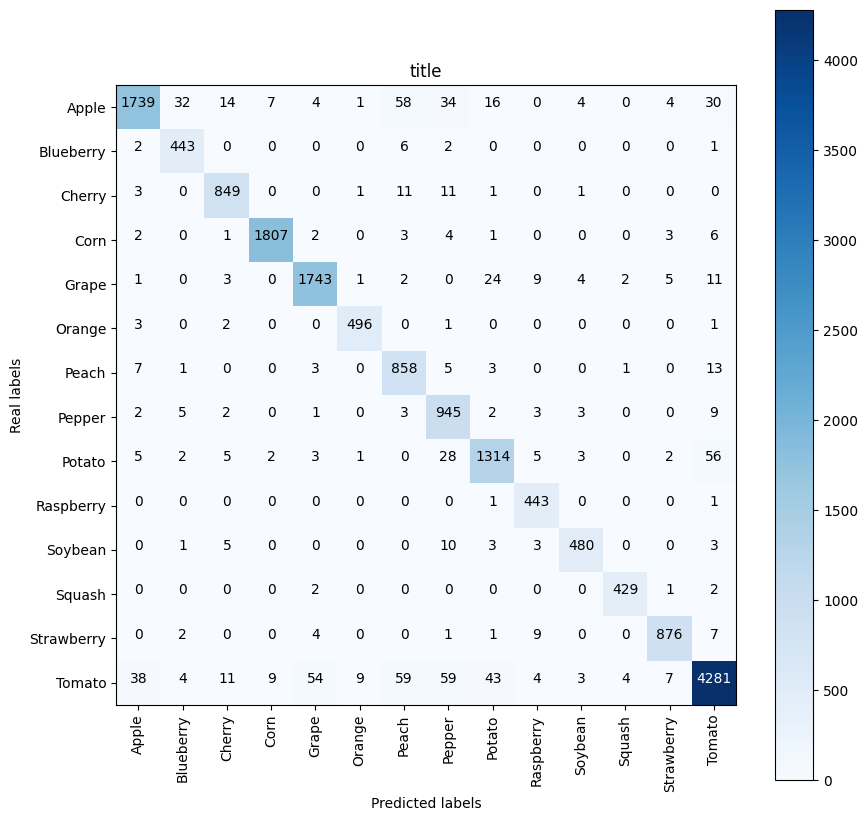

In [22]:
# Confusion Matrix
plot_cm(y_le_test, y_pred)

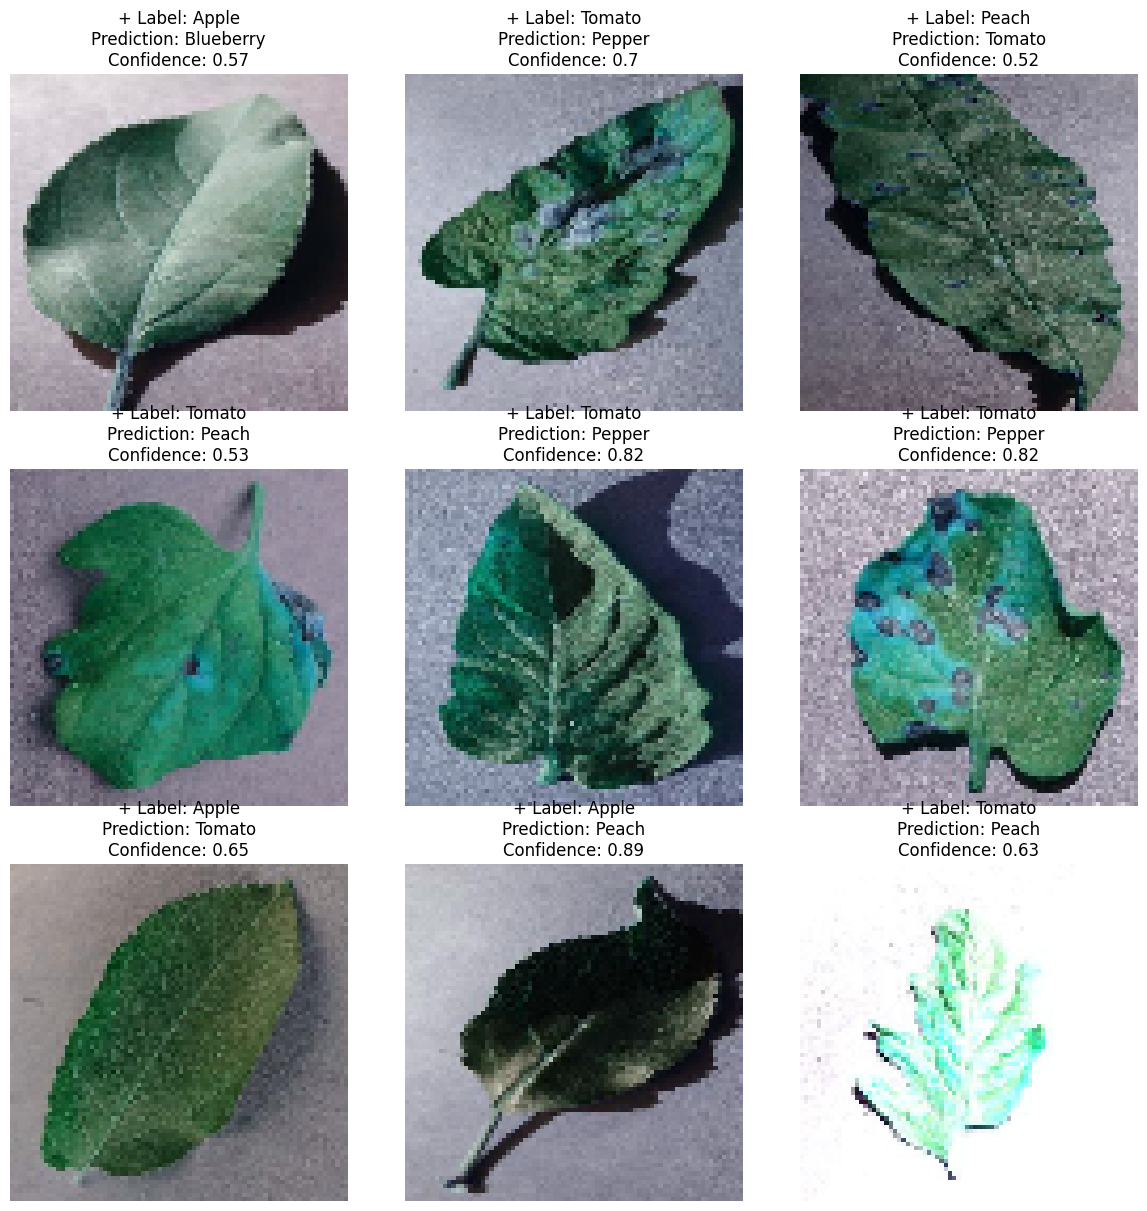

In [23]:
# Ploting images that were labeled wrong
plot_errors(y_pred_model_2_ru_gen, y_pred, X_test, y_le_test)